## Import packages

In [95]:
import numpy as np
from skimage.io import imread, imshow

## Import image

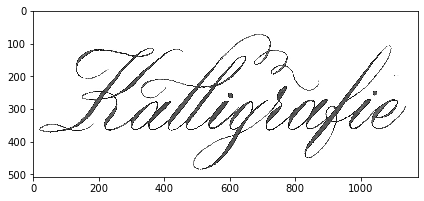

In [96]:
scan = imread('test-files/kalligrafie.png', as_gray=True)
imshow(scan)

## Convert image to binary

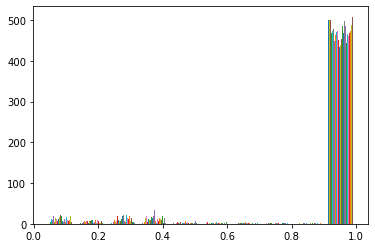

In [97]:
import matplotlib.pyplot as plt
import numpy as np
#plt.hist(scan)
#plt.show()

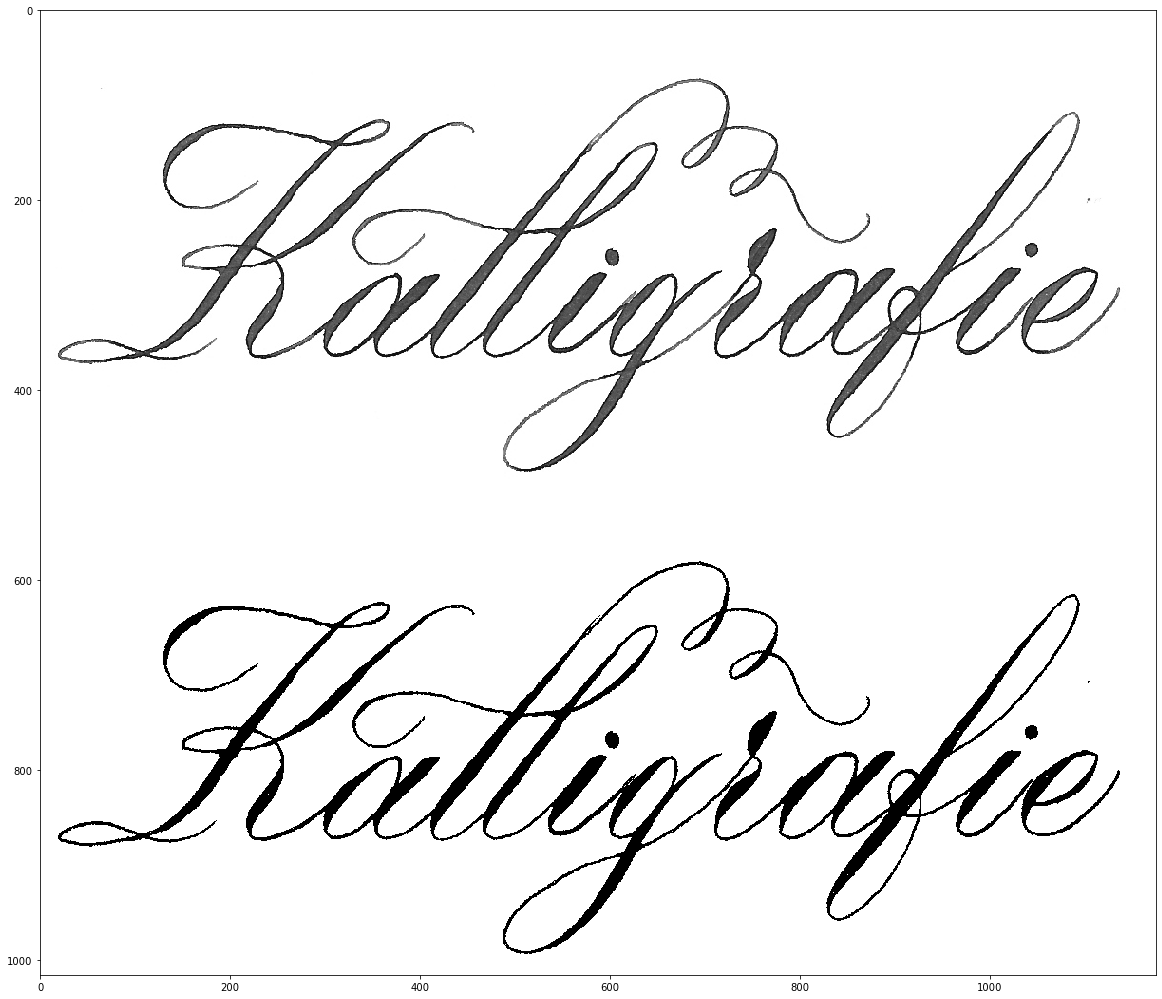

In [110]:
from skimage.filters import threshold_otsu
#threshold = 0.7
threshold = threshold_otsu(scan)

binary = scan > threshold
both = np.vstack((scan, binary))
plt.figure(figsize=(20, 20))
plt.imshow(both, cmap='gray', interpolation='nearest')

## Remove islands

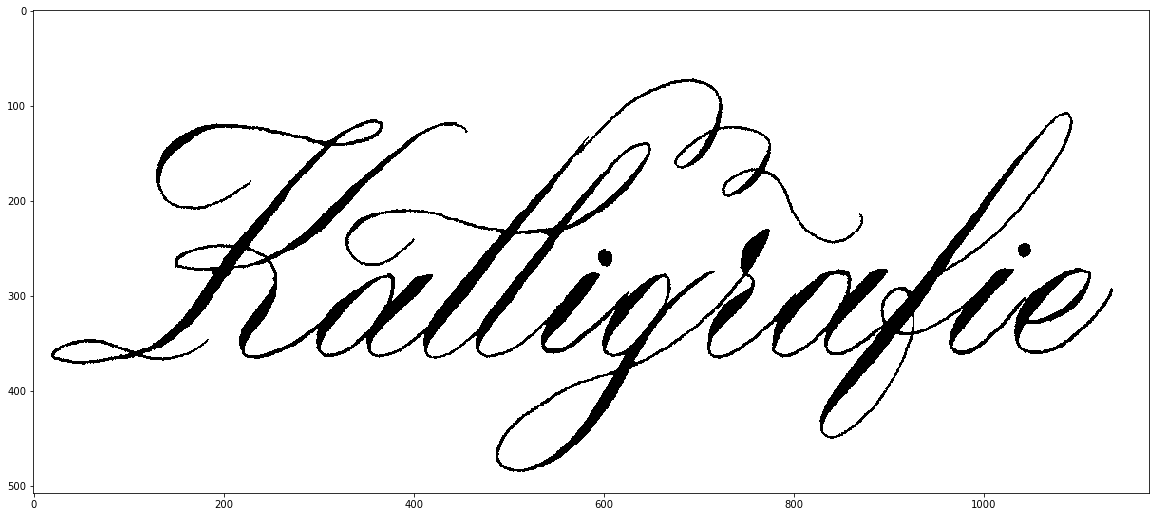

In [163]:
import skimage.morphology as mrp

footprint = np.array([
    [1, 1, 0],
    [1, 1, 1],
    [0, 1, 1]
])
footprint = np.array([
    [1, 1],
    [1, 1]
])

x= mrp.remove_small_holes(binary)
x= mrp.remove_small_objects(x)

plt.
plt.imshow(x, cmap='gray', interpolation='nearest')

## Contour tracing

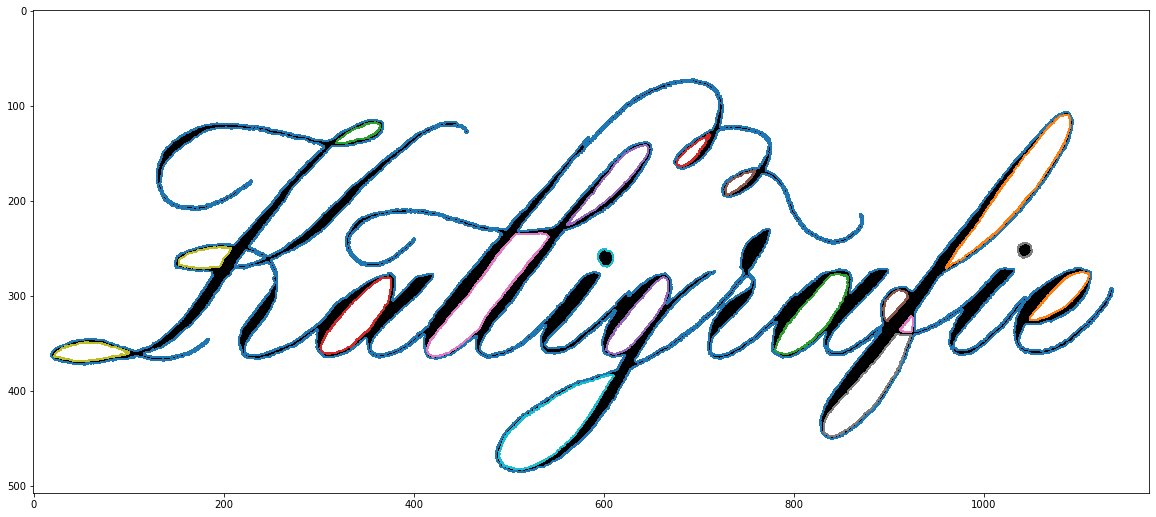

In [205]:
from skimage import measure

contours = measure.find_contours(x)



# Display the image and plot all contours found
plt.rcParams['figure.figsize'] = (20, 20)

fig, ax = plt.subplots()
ax.imshow(x, cmap='gray', interpolation='nearest')

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, antialiased=False)

plt.show()

In [279]:
for contour in contours:
    print(len(contour))

14117
587
139
137
341
117
521
61
165
69
99
225
331
315
293
117
61
403
215
443


## Corner detection

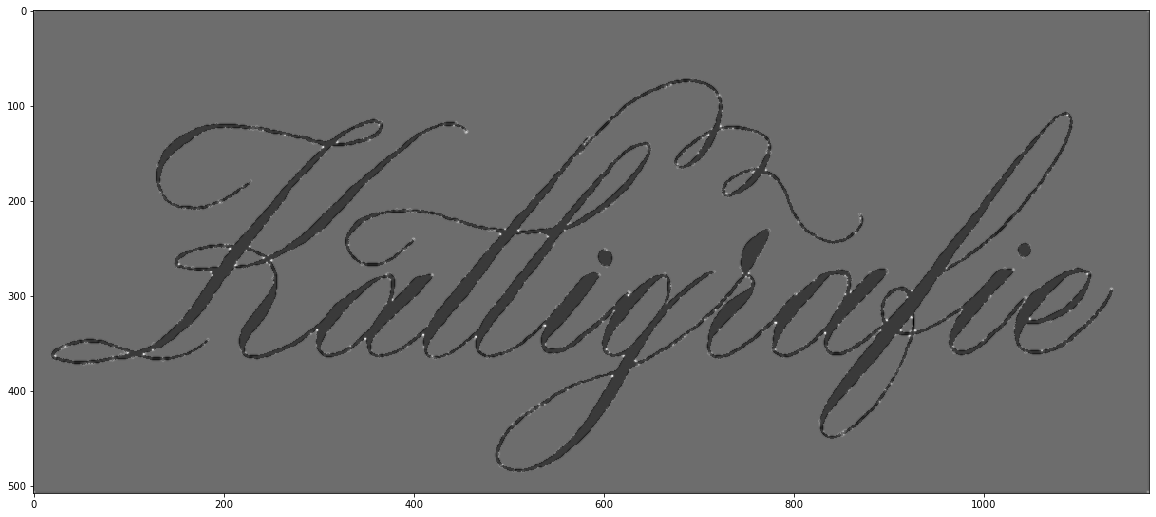

In [270]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks

corners = corner_harris(x)

fig, ax = plt.subplots()
ax.imshow(x, cmap=plt.cm.gray, interpolation='nearest')
ax.imshow(corners, interpolation='nearest', cmap='gray', alpha=0.8)
plt.show()

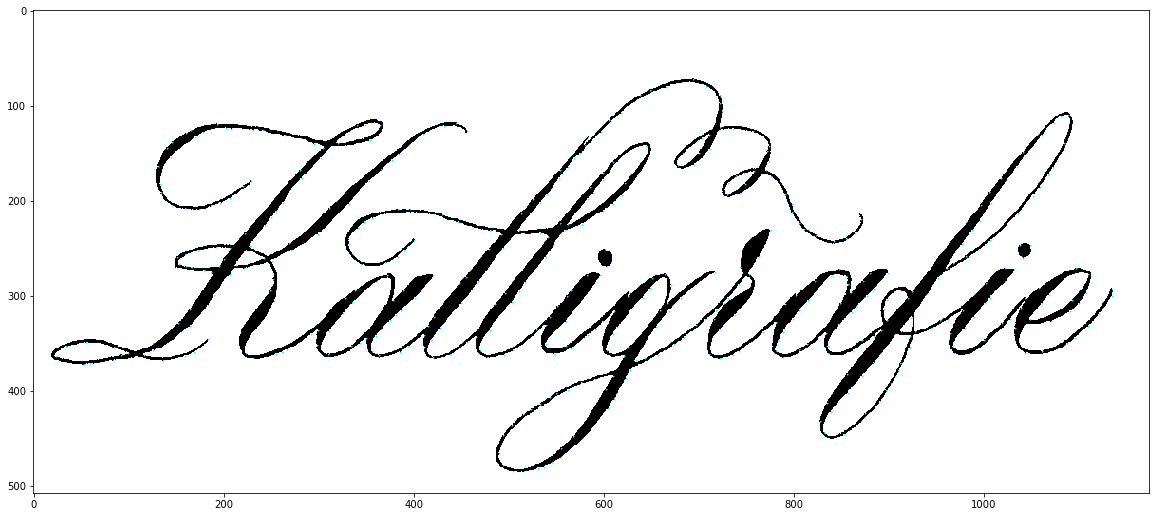

In [268]:
coords = corner_peaks(corner_harris(x), min_distance=5, threshold_rel=0.02)
coords_subpix = corner_subpix(x, coords, window_size=13)

fig, ax = plt.subplots()
ax.imshow(x, cmap=plt.cm.gray, interpolation='nearest')
ax.plot(coords[:, 1], coords[:, 0], color='cyan',
        linestyle='None', marker='+', markersize=1)
plt.show()

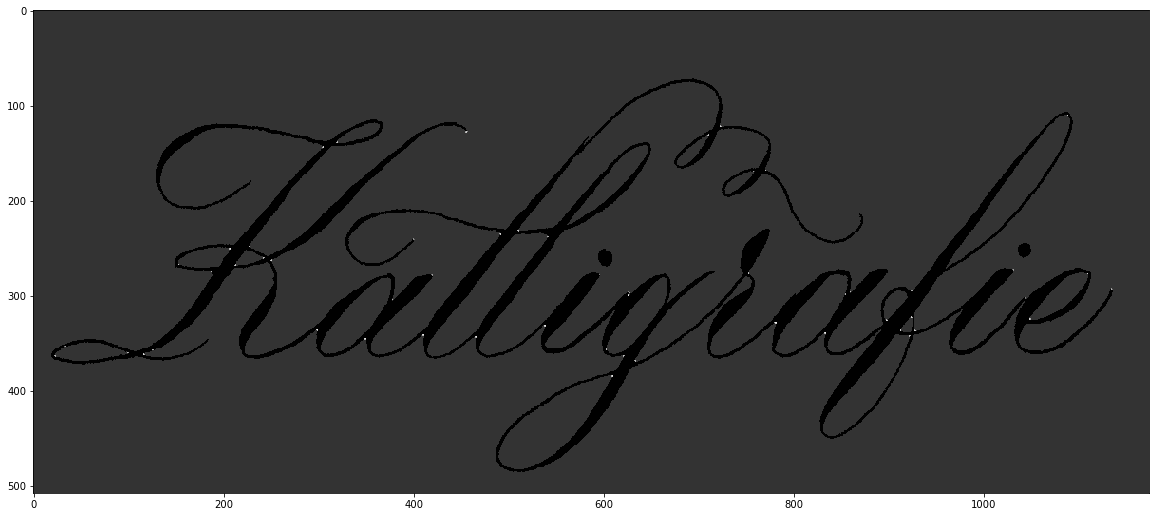

In [274]:
corners[corners < 15] = 0

fig, ax = plt.subplots()
ax.imshow(x, cmap=plt.cm.gray, interpolation='nearest')
ax.imshow(corners, interpolation='nearest', cmap='gray', alpha=0.8)
plt.show()

## Curve fitting

In [276]:
'''least square qbezier fit using penrose pseudoinverse
    >>> V=array
    >>> E,  W,  N,  S =  V((1,0)), V((-1,0)), V((0,1)), V((0,-1))
    >>> cw = 100
    >>> ch = 300
    >>> cpb = V((0, 0))
    >>> cpe = V((cw, 0))
    >>> xys=[cpb,cpb+ch*N+E*cw/8,cpe+ch*N+E*cw/8, cpe]
    >>>
    >>> ts = V(range(11), dtype='float')/10
    >>> M = bezierM (ts)
    >>> points = M*xys #produces the points on the bezier curve at t in ts
    >>>
    >>> control_points=lsqfit(points, M)
    >>> linalg.norm(control_points-xys)<10e-5
    True
    >>> control_points.tolist()[1]
    [12.500000000000037, 300.00000000000017]

https://stackoverflow.com/questions/12643079/b%C3%A9zier-curve-fitting-with-scipy
'''
from numpy import array, linalg, matrix
from scipy.special import comb as nOk # .misc -> .special
Mtk = lambda n, t, k: t**(k)*(1-t)**(n-k)*nOk(n,k)
bezierM = lambda ts: matrix([[Mtk(3,t,k) for k in range(4)] for t in ts])
def lsqfit(points,M):
    M_ = linalg.pinv(M)
    return M_ * points

In [359]:
contour = contours[6]
contour

array([[364.5, 420. ],
       [364. , 419.5],
       [363.5, 419. ],
       ...,
       [363.5, 421. ],
       [364. , 420.5],
       [364.5, 420. ]])

In [334]:
contour = contour[:100]

ts = np.array(range(np.shape(contour)[0]), dtype='float')/10

curve = lsqfit(contour, bezierM(ts))
curve = curve.getA().astype(int) # Matrix -> Array
curve

array([[365, 417],
       [363, 416],
       [360, 416],
       [358, 416]])

In [358]:
from scipy.special import comb as n_over_k
Mtk = lambda n, t, k: t**k * (1-t)**(n-k) * n_over_k(n,k)
BézierCoeff = lambda ts: [[Mtk(3,t,k) for k in range(4)] for t in ts]

fcn = np.log
tPlot = np.array(range(np.shape(contour)[0]), dtype='float')/10
xPlot = np.array(range(np.shape(contour)[0]), dtype='float')/10

Bézier = np.array(BézierCoeff(tPlot)).dot(contour)
residuum = fcn(Bézier[:,0]) - Bézier[:,1]

fig, ax = plt.subplots()
ax.plot(xPlot, fcn(xPlot),   'r-')
#ax.plot(xData, data[:,1],    'ro', label='input')
ax.plot(Bézier[:,0],
        Bézier[:,1],         'k-', label='fit')
ax.plot(xPlot, 10.*residuum, 'b-', label='10*residuum')
ax.plot(contour[:,0],
        contour[:,1], 'ko:', fillstyle='none')
ax.legend()
fig.show()

ValueError: shapes (100,4) and (100,2) not aligned: 4 (dim 1) != 100 (dim 0)

In [335]:
# bezier using library

from libraries.Bezier import Bezier

bezier = Bezier.Curve(np.arange(0, 1, 0.01), curve)
bezier

array([[365.      , 417.      ],
       [364.939702, 416.970299],
       [364.878816, 416.941192],
       [364.817354, 416.912673],
       [364.755328, 416.884736],
       [364.69275 , 416.857375],
       [364.629632, 416.830584],
       [364.565986, 416.804357],
       [364.501824, 416.778688],
       [364.437158, 416.753571],
       [364.372   , 416.729   ],
       [364.306362, 416.704969],
       [364.240256, 416.681472],
       [364.173694, 416.658503],
       [364.106688, 416.636056],
       [364.03925 , 416.614125],
       [363.971392, 416.592704],
       [363.903126, 416.571787],
       [363.834464, 416.551368],
       [363.765418, 416.531441],
       [363.696   , 416.512   ],
       [363.626222, 416.493039],
       [363.556096, 416.474552],
       [363.485634, 416.456533],
       [363.414848, 416.438976],
       [363.34375 , 416.421875],
       [363.272352, 416.405224],
       [363.200666, 416.389017],
       [363.128704, 416.373248],
       [363.056478, 416.357911],
       [36

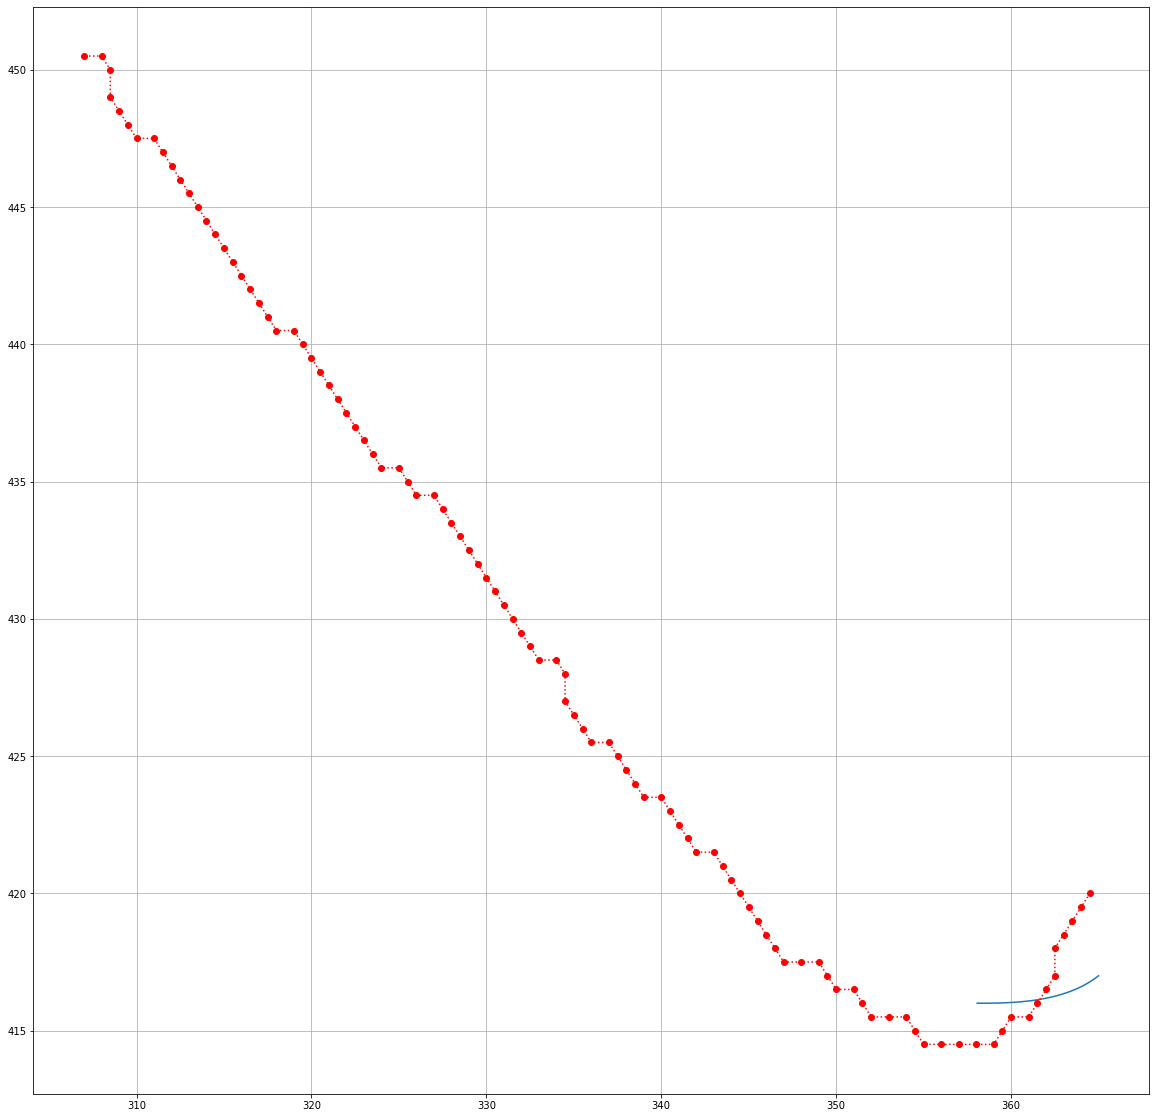

In [336]:
plt.plot(bezier[:,0], bezier[:,1])
plt.plot(
	contour[:, 0],  # x-coordinates.
	contour[:, 1],  # y-coordinates.
	'ro:'           # Styling (red, circles, dotted).
)
plt.grid()
plt.show()

## Curve fitting: Try to implement algorithm myself..
from Curve Fitting with Bézier Cubics by Shao and Zhou 1996

1. Break the data set into segments and sections based on given corner and joint points

2. For each segment Do

3. Begin

4. Compute initial t^_i values for each corner and joint points

5. Compute initial t_ij values for all the data points

6. Do

7. Compute a_i0 and a_i1 for each Bézier curve piece Q_i

8. Compute t_ij values for each data points

9. Compute tˆ_i values for each corner and joint points

10. Compute maximum fitting error FitErr between Ci(j) and Q_i

11. Increase the number of iteration steps NumLoop

12. Until (FitErr < MaxPntErr) or (NumLoop > MaxNumLoop)

13. End